In [ ]:
"""
Fuente: https://github.com/SpikeLab-CL/desafio_spike_cuencas

Como dice el título, vamos a predecir los caudales extremos para cuencas en Chile. 
Para eso armamos un dataset usando datos públicos y reales de estaciones metereológicas.

Cada fila representa una medida de caudal diaria en una estación medidora. 
La medición de caudal estará asociada a características de la cuenca (fijas) 
y a mediciones diarias de temperatura y precipitación de estaciones cercanas.

"""

In [62]:
"""
Objetivo:
Algunas de las preguntas claves que en Chile debemos responder son:

P1) ¿Ha aumentado la frecuencia de olas de calor en Chile? Para esto se deben analizar las estaciones de temperatura.

P2) ¿Existe una relación entre olas de calor y eventos extremos de caudal?

P3) De existir una relación entre olas de calor y eventos extremos de caudal, 
¿se puede explicar este evento extremo por las características de la cuenca en donde ocurre el peakflow?
"""

'\nObjetivo:\nAlgunas de las preguntas claves que en Chile debemos responder son:\n\nP1) ¿Ha aumentado la frecuencia de olas de calor en Chile? Para esto se deben analizar las estaciones de temperatura.\n\nP2) ¿Existe una relación entre olas de calor y eventos extremos de caudal?\n\nP3) De existir una relación entre olas de calor y eventos extremos de caudal, \n¿se puede explicar este evento extremo por las características de la cuenca en donde ocurre el peakflow?\n'

In [81]:
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [64]:
# El archivo caudal_extra.csv contiene todos los datos que van a necesitar para este desafío. 
# Esta base la produjimos en Spike y sintetiza información de caudal, precipitación y temperatura.
"""
Esta base tiene las siguientes variables:

gauge_id: id de la cuenca.
nombre: nombre del lugar en la cuenca donde está la estación.
codigo_estacion: el código de la estación de medición de caudal.

fecha: día de medición.
caudal: medición de caudal de ese día.
precip_promedio: precipitación promedio de ese día en la cuenca.
temp_max_promedio: temperatura máxima promedio de ese día en la cuenca.

-----

u'gauge_id' - gauge_name'
u'nombre' - u'nombre_sub_cuenca'
u'codigo_cuenca'
u'codigo_estacion'

u'altura', u'latitud', u'longitud'                    # estaticas
u'caudal', u'precip_promedio', u'temp_max_promedio'   # dinamicas
       
otros:
u'fecha'
u'cantidad_observaciones'
u'fuente'
u'institucion'
"""


cwd = os.getcwd()
print (cwd)
print( "")


# Descargamos los datos
caudal_extra_df = pd.read_csv('../caudal_extra.csv') #, delimiter='\t'
print ("----------------")
cantidad_null = caudal_extra_df.isnull().sum().sum()
if( cantidad_null > 0 ):
    print( " 		HAY NULLs EN LA MC... {}\n".format(cantidad_null))
    """
    De esta manera, cada día de medición de caudal va a estar asociada a una única medición de temperatura y 
    de precipitación relevante (aunque puede haber cuencas sin estaciones de temperatura o precipitación).
    """
print ("----------------")
print ("")
print ("")
print ("")

print (caudal_extra_df.head(10))
#print caudal_extra_df.tail(10)
print ("")
print (caudal_extra_df.describe())
print ("")
print (caudal_extra_df.columns)
print ("")
print (caudal_extra_df.dtypes)
print ("")
print (caudal_extra_df.shape)
print ("----------------")
print ("----------------")

C:\Users\Tito\Desktop\My Tito\1 Principal\Emprendimientos\Desafio\src

----------------
 		HAY NULLs EN LA MC... 179330

----------------



   Unnamed: 0  codigo_estacion institucion   fuente                  nombre  \
0           0          4540001         DGA  dga_web  Rio Grande En Paloma 1   
1           1          4540001         DGA  dga_web  Rio Grande En Paloma 1   
2           2          4540001         DGA  dga_web  Rio Grande En Paloma 1   
3           3          4540001         DGA  dga_web  Rio Grande En Paloma 1   
4           4          4540001         DGA  dga_web  Rio Grande En Paloma 1   
5           5          4540001         DGA  dga_web  Rio Grande En Paloma 1   
6           6          4540001         DGA  dga_web  Rio Grande En Paloma 1   
7           7          4540001         DGA  dga_web  Rio Grande En Paloma 1   
8           8          4540001         DGA  dga_web  Rio Grande En Paloma 1   
9           9          4540001         DGA  dga_web  Rio Grande En Pa

In [65]:

listado_dias =  sorted(caudal_extra_df["fecha"].unique())
cantidad_listado_dias = len(listado_dias)
primer_dia = listado_dias[0]
ultimo_dia = listado_dias[cantidad_listado_dias-1]

listado_gauge_id =  sorted(caudal_extra_df["gauge_id"].unique())
cantidad_listado_gauge_id = len(listado_gauge_id)

listado_nombre =  sorted(caudal_extra_df["nombre"].unique())
cantidad_listado_nombre = len(listado_nombre)

listado_codigo_estacion =  sorted(caudal_extra_df["codigo_estacion"].unique())
cantidad_listado_codigo_estacion = len(listado_codigo_estacion)

listado_codigo_cuenca =  sorted(caudal_extra_df["codigo_cuenca"].unique())
cantidad_listado_codigo_cuenca = len(listado_codigo_cuenca)

print( "primer_dia: {} - ultimo_dia: {} (total dias: {})".format(primer_dia, ultimo_dia, cantidad_listado_dias))
print( "")
print( "cantidad_listado_gauge_id: {}".format(cantidad_listado_gauge_id))
#print( "listado_nombre: \n{}".format(listado_nombre))
print( "")
print( "cantidad_listado_nombre: {}".format(cantidad_listado_nombre))
#print( "listado_gauge_id: \n{}".format(listado_gauge_id))
print( "")
print( "cantidad_listado_codigo_estacion: {}".format(cantidad_listado_codigo_estacion))
#print( "listado_codigo_estacion: \n{}".format(listado_codigo_estacion))
print( "")
print( "cantidad_listado_codigo_cuenca: {}".format(cantidad_listado_codigo_cuenca))
print( "listado_codigo_cuenca: \n{}".format(listado_codigo_cuenca))

print( "")
print( "")
print( "")

# Chequeamos que los que un gauge este siempre asociado al mismo nmbre y codigo estacion
if( True ):
    aux_1_df = caudal_extra_df[["gauge_id", "nombre", "codigo_estacion"]].drop_duplicates(subset=["gauge_id", "nombre", "codigo_estacion"], inplace=False)
    print( aux_1_df.head(10))
    print( aux_1_df.shape)
    del aux_1_df

print( "----------------")

primer_dia: 1960-01-02 00:00:00+00:00 - ultimo_dia: 2018-03-09 00:00:00+00:00 (total dias: 21252)

cantidad_listado_gauge_id: 133

cantidad_listado_nombre: 133

cantidad_listado_codigo_estacion: 133

cantidad_listado_codigo_cuenca: 29
listado_codigo_cuenca: 
[10, 12, 21, 32, 34, 38, 43, 45, 47, 52, 54, 57, 60, 71, 73, 81, 83, 91, 94, 103, 104, 107, 110, 111, 113, 115, 117, 122, 128]



     gauge_id                                 nombre  codigo_estacion
0     4540001                 Rio Grande En Paloma 1          4540001
135  10414001              Rio Maullin En Las Quemas         10414001
261  11040001         Rio Palena Bajo Junta Rosselot         11040001
394   6019003  Rio Cachapoal En Puente Arqueado (Ca)          6019003
506  11530000     Rio Baker En Desague Lago Bertrand         11530000
604  10311001                     Rio Bueno En Bueno         10311001
700  10704002    Rio Futaleufu Ante Junta Rio Malito         10704002
788   7317003            Rio Melado En Zona De Pres

In [66]:
# función auxiliar
def detectar_umbrales_1(lista_scores):		# Inserconsultore
	try:
		num_datos_lista = lista_scores.shape[0]
	except:
		num_datos_lista = len(lista_scores)
	if( num_datos_lista > 0 ):
		lista_scores = sorted(lista_scores)
		Q1 = float(np.percentile(lista_scores, 25))
		mediana = float(np.percentile(lista_scores, 50))
		Q3 = float(np.percentile(lista_scores, 75))
		Q90 = float(np.percentile(lista_scores, 90))
		RIC = Q3 - Q1
		LIF = Q1 - 1.5*RIC
		UIF = Q3 + 1.5*RIC
	else:
		return -9999, -9999

#	return LIF, UIF
	return Q1, Q90

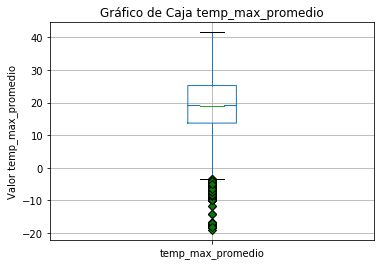

Umbral_temp_1: 12.3844442367554 - Umbral_temp_2: 28.94547386169432


In [67]:
"""
P1) ¿Ha aumentado la frecuencia de olas de calor en Chile? Para esto se deben analizar las estaciones de temperatura.
"""

# Detectamos outliers para definir olas de calor en Chile
green_diamond = dict(markerfacecolor='g', marker='D')
myFig = plt.figure()
    
boxplot_montos_Totales = caudal_extra_df.boxplot(column=['temp_max_promedio'], grid=True, notch=True, flierprops=green_diamond, showfliers=True)

plt.title(u'Gráfico de Caja temp_max_promedio')
plt.xlabel(u'')
plt.ylabel(u'Valor temp_max_promedio')
# plt.margins(0.1)
plt.subplots_adjust(left=0.15)
# plt.ylim(0, 0.4)
# plt.yticks([0, 1.163032, 2.352395, 4.219307, 16.478374])
#plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 6398.278689])
plt.grid(True)
# myFig.savefig("{}/boxplot_montos_Totales.svg".format(ruta_Data), format="svg")
plt.show()


listado_temp_max = caudal_extra_df[~caudal_extra_df["temp_max_promedio"].isnull()]["temp_max_promedio"].unique()

Umbral_temp_1, Umbral_temp_2 = detectar_umbrales_1(listado_temp_max)
print( "Umbral_temp_1: {} - Umbral_temp_2: {}".format(Umbral_temp_1, Umbral_temp_2))



if( False ):
    listado_temp_max_promedio =  sorted(caudal_extra_df["temp_max_promedio"].unique())
    cantidad_listado_temp_max_promedio = len(listado_temp_max_promedio)
    print( "")
    print( "cantidad_listado_temp_max_promedio: {}".format(cantidad_listado_temp_max_promedio))
    print( "listado_temp_max_promedio: \n{}".format(listado_temp_max_promedio))




fecha formateada
agregamos Num_hay_ola_de_calor
                      fecha  Num_hay_ola_de_calor
0 1960-01-31 00:00:00+00:00                    14
1 1960-02-29 00:00:00+00:00                    18
2 1960-03-31 00:00:00+00:00                     7
3 1960-04-30 00:00:00+00:00                     1
4 1960-05-31 00:00:00+00:00                     0
5 1960-06-30 00:00:00+00:00                     0
6 1960-07-31 00:00:00+00:00                     0
7 1960-08-31 00:00:00+00:00                     0
8 1960-09-30 00:00:00+00:00                     0
9 1960-10-31 00:00:00+00:00                     0


C:\Users\Tito\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


<Figure size 432x288 with 0 Axes>

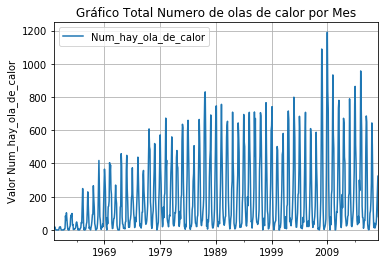




En efecto, los peak de calor aumentan a medida que pasa el tiempo.
En el gráfico podemos ver la cantidad de peak de calor por mes, asumiendo peak de calor temperaturas sobre 28.94 (el 90 percentil de la variable 'temp_max_promedio')
:D


In [68]:
#caudal_extra_df = caudal_extra_df.head(100000) # para pruebas


caudal_extra_df['fecha'] = pd.to_datetime(caudal_extra_df['fecha'])#, errors = 'coerce'
print( "fecha formateada")
caudal_extra_df.sort_values(by=["fecha"], ascending=True, inplace=True)

# caudal_extra_df["mes"] = caudal_extra_df['fecha'].dt.month
# print "agregamos mes"
# caudal_extra_df["anno"] = caudal_extra_df['fecha'].dt.year
# print "agregamos anno"
#caudal_extra_df["Num_hay_ola_de_calor"] = caudal_extra_df.apply(lambda row: 1 if float(row['temp_max_promedio']) > Umbral_temp_2 else 0, axis=1)
caudal_extra_df["Num_hay_ola_de_calor"] = (caudal_extra_df['temp_max_promedio'] > Umbral_temp_2)*1
print( "agregamos Num_hay_ola_de_calor")
caudal_extra_AGRUPADO_df = caudal_extra_df.set_index('fecha').resample('M').sum()

caudal_extra_AGRUPADO_df.reset_index(drop=False, inplace=True)
print( caudal_extra_AGRUPADO_df[["fecha", "Num_hay_ola_de_calor"]].head(10))



myFig = plt.figure()
    
caudal_extra_AGRUPADO_df.plot(x='fecha', y='Num_hay_ola_de_calor', kind = 'line')

plt.title(u'Gráfico Total Numero de olas de calor por Mes')
plt.xlabel(u'')
plt.ylabel(u'Valor Num_hay_ola_de_calor')
# plt.margins(0.1)
plt.subplots_adjust(left=0.15)
# plt.ylim(0, 0.4)
# plt.yticks([0, 1.163032, 2.352395, 4.219307, 16.478374])
#plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 6398.278689])
plt.grid(True)
# myFig.savefig("{}/boxplot_montos_Totales.svg".format(ruta_Data), format="svg")
plt.show()

print("")
print("")
print("")

respuesta1 = "En efecto, los peak de calor aumentan a medida que pasa el tiempo.\nEn el gráfico podemos ver la cantidad de peak de calor por mes, asumiendo peak de calor temperaturas sobre 28.94 (el 90 percentil de la variable 'temp_max_promedio')\n:D"
print( respuesta1)

Umbral_caudal_1: 22.1985 - Umbral_caudal_2: 926.5481000000005


                      fecha  Num_hay_ola_de_calor  Num_hay_peak_caudal
0 1960-01-31 00:00:00+00:00                    14                    0
1 1960-02-29 00:00:00+00:00                    18                    0
2 1960-03-31 00:00:00+00:00                     7                    0
3 1960-04-30 00:00:00+00:00                     1                    0
4 1960-05-31 00:00:00+00:00                     0                    0
5 1960-06-30 00:00:00+00:00                     0                    4
6 1960-07-31 00:00:00+00:00                     0                    0
7 1960-08-31 00:00:00+00:00                     0                    0
8 1960-09-30 00:00:00+00:00                     0                    0
9 1960-10-31 00:00:00+00:00                     0                    0


                      fecha  hay_ola_de_calor  hay_peak_caudal
0 1960-01-31 00:00:00+00:00                 1                0
1 1960-02-29 00:00:00+00:00

C:\Users\Tito\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


<Figure size 432x288 with 0 Axes>

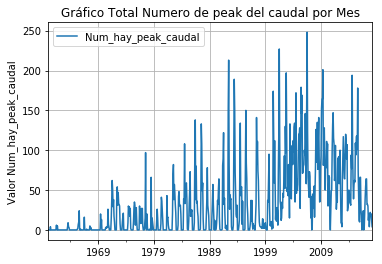




Vemos la correlacion de la existencia de olas de calor con la existencia de peak de caudal para todos los meses. 
 La correlación es de 0.04365, lo cual nos indica que no existe una relación aparente.
Además, si vemos los gráficos, estos muestran claramente que a medida que pasa el tiempo, los peak de caudal aumentan también.    
 :D


In [69]:
"""
P2) ¿Existe una relación entre olas de calor y eventos extremos de caudal?
"""
# Primero detectamos los eventos extremos de caudal

listado_caudal = caudal_extra_df[~caudal_extra_df["caudal"].isnull()]["caudal"].unique()

Umbral_caudal_1, Umbral_caudal_2 = detectar_umbrales_1(listado_caudal)
print( "Umbral_caudal_1: {} - Umbral_caudal_2: {}".format(Umbral_caudal_1, Umbral_caudal_2))
print("")
print("")


caudal_extra_df.sort_values(by=["fecha"], ascending=True, inplace=True)

caudal_extra_df["Num_hay_peak_caudal"] = (caudal_extra_df['caudal'] > Umbral_caudal_2)*1
# print(caudal_extra_df["Num_hay_peak_caudal"].head(10))

datos_AGRUPADO_df = caudal_extra_df.set_index('fecha').resample('M').sum()

datos_AGRUPADO_df.reset_index(drop=False, inplace=True)

print( datos_AGRUPADO_df[["fecha", "Num_hay_ola_de_calor", "Num_hay_peak_caudal"]].head(10))
# print( caudal_extra_df[["fecha", "Num_hay_ola_de_calor", "Num_hay_peak_caudal"]].head(10))



datos_AGRUPADO_df["hay_ola_de_calor"] = (datos_AGRUPADO_df['Num_hay_ola_de_calor'] > 0)*1
datos_AGRUPADO_df["hay_peak_caudal"] = (datos_AGRUPADO_df['Num_hay_peak_caudal'] > 0)*1


print("")
print("")

print( datos_AGRUPADO_df[["fecha", "hay_ola_de_calor", "hay_peak_caudal"]].head(10))
print(datos_AGRUPADO_df[["hay_ola_de_calor", "hay_peak_caudal"]].corr())


print("")
print("")
print("")


myFig = plt.figure()
    
datos_AGRUPADO_df.plot(x='fecha', y='Num_hay_peak_caudal', kind = 'line')

plt.title(u'Gráfico Total Numero de peak del caudal por Mes')
plt.xlabel(u'')
plt.ylabel(u'Valor Num_hay_peak_caudal')
# plt.margins(0.1)
plt.subplots_adjust(left=0.15)
# plt.ylim(0, 0.4)
# plt.yticks([0, 1.163032, 2.352395, 4.219307, 16.478374])
#plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 6398.278689])
plt.grid(True)
# myFig.savefig("{}/boxplot_montos_Totales.svg".format(ruta_Data), format="svg")
plt.show()


print("")
print("")
print("")
respuesta2 = "Vemos la correlacion de la existencia de olas de calor con la existencia de peak de caudal para todos los meses. \n La correlación es de 0.04365, lo cual nos indica que no existe una relación aparente."
respuesta2_2 = "Además, si vemos los gráficos, estos muestran claramente que a medida que pasa el tiempo, los peak de caudal aumentan también.    \n :D"
print( respuesta2)
print( respuesta2_2)

In [113]:
#pasos que pude haber hecho junto con los pasos anteriores

caudal_extra_df["hay_ola_de_calor"] = (caudal_extra_df['Num_hay_ola_de_calor'] > 0)*1
caudal_extra_df["hay_peak_caudal"] = (caudal_extra_df['Num_hay_peak_caudal'] > 0)*1
caudal_extra_df = caudal_extra_df[["altura", "latitud", "longitud", "precip_promedio", "temp_max_promedio", "hay_ola_de_calor", "hay_peak_caudal"]]#, "caudal"

caudal_extra_df.dropna(inplace=True)


print(caudal_extra_df.head(10))
print(caudal_extra_df.columns)

        altura    latitud   longitud  precip_promedio  temp_max_promedio  \
676041     440 -33.496101 -70.816704              0.0          26.700001   
661132     440 -33.496101 -70.816704              0.0          27.400000   
668534     440 -33.496101 -70.816704              0.0          31.799999   
663812     440 -33.496101 -70.816704              0.0          31.000000   
671263     440 -33.496101 -70.816704              0.0          29.600000   
675658     440 -33.496101 -70.816704              0.0          31.200001   
667326     440 -33.496101 -70.816704              0.0          29.200001   
660770     440 -33.496101 -70.816704              0.0          23.900000   
671656     440 -33.496101 -70.816704              0.0          30.000000   
662325     440 -33.496101 -70.816704              0.0          29.400000   

        hay_ola_de_calor  hay_peak_caudal  
676041                 0                0  
661132                 0                0  
668534                 1       

Para responder a la pregunta, usaremos un modelo RF, ya que no requiere mucho pre-procesamiento de datos, suele ser efectivo en estas condiciones (XGBOOST también), y podemos ver sus caracteristicas importantes de forma sencilla
Feature ranking:
1 feature 2 0.41496753118374585 == longitud
2 feature 1 0.22640604611943477 == latitud
3 feature 0 0.145618346158607 == altura
4 feature 4 0.1179183172320069 == temp_max_promedio
5 feature 3 0.0879262613176337 == precip_promedio
6 feature 5 0.007163497988571714 == hay_ola_de_calor


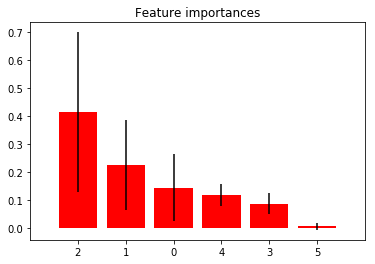

In [121]:
"""
P3) De existir una relación entre olas de calor y eventos extremos de caudal, 
¿se puede explicar este evento extremo por las características de la cuenca en donde ocurre el peakflow?
"""
# Aquí se pone interesante el problema
print("Para responder a la pregunta, usaremos un modelo RF, ya que no requiere mucho pre-procesamiento de datos, suele ser efectivo en estas condiciones (XGBOOST también), y podemos ver sus caracteristicas importantes de forma sencilla")


target = "hay_peak_caudal"

y_train = caudal_extra_df[target]
X_train = caudal_extra_df.drop([target], axis=1).copy()
# print(y_train.head(5))
# print(X_train.head(5
features_usadas = X_train.columns
# print("features_usadas: {}".format(features_usadas))


modelo = RandomForestClassifier(random_state = 0)
cv_total = 3

# grid_values = {'n_estimators': [5, 10, 20, 50, 100], 	# Debe ser grande para grandes DB para evitar OverFiting
# 				'max_features': [3, 5, 9, "auto", None], 		# default (None) suele resultar bien, pero se puede obtener mejores resultados modificandolo # valores pequeños suelen resudir el sobre ajuste
# 				'max_depth': [6, 10, 20, 50, None]				# Profundidad de cada arbol
# 				}
grid_values = {'n_estimators': [5], 	# Debe ser grande para grandes DB para evitar OverFiting
				'max_features': [2], 		# default (None) suele resultar bien, pero se puede obtener mejores resultados modificandolo # valores pequeños suelen resudir el sobre ajuste
				'max_depth': [6]				# Profundidad de cada arbol
				}

if( False ):
    my_scorer = "f1"
    Objetivo_optimizacion_usado = f1_score

    forest = GridSearchCV(modelo, param_grid = grid_values, scoring = my_scorer, cv = cv_total, n_jobs = 1)

    forest.fit(X_train, y_train)

    importances = forest.best_estimator_.feature_importances_

    print("importances:\n{}".format(importances))

if( True ):
    std = np.std([tree.feature_importances_ for tree in forest.best_estimator_.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):   
        print( "{} feature {} {} == {}".format(f + 1, indices[f], importances[indices[f]], features_usadas[indices[f]] )  )

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()



respuesta3 = "Evidentemente hemos realizado varios supuestos. Ej: El target es en el mismo día que tenemos los parametros, en la practica esto no es factible, ya que no tenemos datos para usar en el modelo. \n No regularizamos. \n No probamos rendimiento con Test."
respuesta3_2 = "Pero lo importante es mostrar una forma de mostrar una relación entre los peak y las caracteristicas de la cuenca. Si tenemos"

In [117]:
"""
Resultados del modelo optenidos, según estos respondemos la pregunta
importances:
[0.14561835 0.22640605 0.41496753 0.08792626 0.11791832 0.0071635 ]
Feature ranking:
1 feature 2 0.41496753118374585 == longitud
2 feature 1 0.22640604611943477 == latitud
3 feature 0 0.145618346158607 == altura
4 feature 4 0.1179183172320069 == temp_max_promedio
5 feature 3 0.0879262613176337 == precip_promedio
6 feature 5 0.007163497988571714 == hay_ola_de_calor
"""
respuesta3_4 = "Según lo visto, las caracteristicas de la cuenca son muy importantes. \n Podríamos por ejemplo deducir que la longitud es mayor, es más probable de existir un mayor caudal. \n Sorprendentemente, la variable 'hay_ola_de_calor' esta en ultimo lugar, no pondría las manos al fuego con este modelo, a menos que lo entrene con más hyper-parametros"
print(respuesta3_4)

Según lo visto, las caracteristicas de la cuenca son muy importantes. 
 Podríamos por ejemplo deducir que la longitud es mayor, es más probable de existir un mayor caudal. 
 Sorprendentemente, la variable 'hay_ola_de_calor' esta en ultimo lugar, no pondría las manos al fuego con este modelo, a menos que lo entrene con más hyper-parametros
